# Patch Injection Evaluation with LLaVA (Colab-ready)

This notebook **does not train** a patch. It assumes you already have a trained patch stored as a PyTorch tensor.

It will:
1. Load a pre-trained adversarial patch.
2. Load a LLaVA model for vision-language QA.
3. Test one image (`nature.jpeg`) with and without the patch using 6 predefined questions.
4. Randomly patch a small set of public images (here: example images from the COCO 2017 val set), ask the same questions, and compute attack success rates.

You only need to **set the correct paths** to your patch and `nature.jpeg` in the configuration cell below, then run all cells top to bottom.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# Install core dependencies for LLaVA + vision
!pip install -q "transformers==4.48.3" accelerate torch torchvision pillow sentencepiece


In [ ]:
# === CONFIGURATION ===


USE_GOOGLE_DRIVE = True

# Path to the pre-trained patch tensor (.pt) file
# The tensor is expected to have shape (1, 3, P, P)
PATCH_PATH = "/content/drive/MyDrive/Attack_Generation/data/images/dog_patch_tensor.pt"  # <-- CHANGE THIS

# Path to clean test image nature.jpeg
NATURE_IMAGE_PATH = "/content/drive/MyDrive//Attack_Generation/data/images/nature.jpeg"     # <-- CHANGE THIS

# Which LLaVA model to use
LLAVA_MODEL_ID = "llava-hf/llava-1.5-7b-hf"

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted.")
else:
    print("Not using Google Drive. Make sure PATCH_PATH and NATURE_IMAGE_PATH are correct.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import re
from typing import Dict, Any, List

from transformers import AutoProcessor, LlavaForConditionalGeneration

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load LLaVA model + processor
processor = AutoProcessor.from_pretrained(LLAVA_MODEL_ID)
model = LlavaForConditionalGeneration.from_pretrained(
    LLAVA_MODEL_ID,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None,
)
model.eval()
print("Loaded LLaVA model:", LLAVA_MODEL_ID)

# Load pre-trained patch (no training here)
patch = torch.load(PATCH_PATH, map_location=device)
if patch.ndim == 3:
    patch = patch.unsqueeze(0)  # (1, 3, P, P)
patch = patch.to(device)
patch.requires_grad_(False)
print("Loaded patch from:", PATCH_PATH, "with shape", tuple(patch.shape))

# Basic image <-> tensor helpers
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Loaded LLaVA model: llava-hf/llava-1.5-7b-hf
Loaded patch from: /content/drive/MyDrive/Attack_Generation/data/images/dog_patch_tensor.pt with shape (1, 3, 96, 96)


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import re
from typing import Dict, Any, List

from transformers import AutoProcessor, LlavaForConditionalGeneration
# === Patch application ===
def apply_patch_to_pil(img_pil: Image.Image, patch_tensor: torch.Tensor) -> Image.Image:
    """Apply patch to a random valid location on the image.
    img_pil: PIL RGB image
    patch_tensor: (1, 3, P, P)
    Returns patched PIL image.
    """
    img = to_tensor(img_pil).to(device)  # (3, H, W)
    P = patch_tensor.shape[-1]
    _, H, W = img.shape

    if P > H or P > W:
        raise ValueError(f"Patch size {P} is larger than image size {(H, W)}")

    # Random top-left position where the patch fits
    top = random.randint(0, H - P)
    left = random.randint(0, W - P)

    patched = img.clone()
    patched[:, top:top+P, left:left+P] = patch_tensor[0]

    return to_pil(patched.cpu().clamp(0, 1))

# === LLaVA QA helper ===
def llava_answer(img_pil: Image.Image, question: str, max_new_tokens: int = 64) -> str:
    """Run LLaVA on a single image + question and return the decoded answer string."""
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    inputs = processor(text=prompt, images=img_pil, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )
    out = processor.batch_decode(output_ids, skip_special_tokens=True)[0]

    if "ASSISTANT:" in out:
        out = out.split("ASSISTANT:", 1)[-1]
    return out.strip()

# === Question set ===
QUESTIONS = [
    ("q1", "Is there a dog in this image? Answer only 'yes' or 'no'.", "yesno"),
    ("q2", "How many dogs do you see in this image? Answer with a number.", "number"),
    ("q3", "Are there any animals visible in this picture? Answer only 'yes' or 'no'.", "yesno"),
    ("q4", "Is the object in this image can bark?", "free"),
    ("q5", "Is the object in this image can bite?", "free"),
    ("q6", "What kind of food the objects need in the image?", "free"),
]

def normalize_answer(ans: str, qtype: str) -> str:
    """Simple normalization so we can compare clean vs patched answers."""
    s = ans.strip().lower()

    if qtype == "yesno":
        if "yes" in s and "no" not in s:
            return "yes"
        if "no" in s:
            return "no"
        return s

    if qtype == "number":
        m = re.search(r"\d+", s)
        if m:
            return m.group(0)
        return s


    s = re.sub(r"\s+", " ", s)
    return s

def evaluate_image_pair(img_clean_pil: Image.Image, img_patched_pil: Image.Image) -> Dict[str, Any]:
    """Ask all QUESTIONS on clean & patched image.
    Return per-question results + attack success rate.
    """
    per_question = []
    changed_count = 0

    for qid, q_text, qtype in QUESTIONS:
        clean_ans = llava_answer(img_clean_pil, q_text)
        patched_ans = llava_answer(img_patched_pil, q_text)

        norm_clean = normalize_answer(clean_ans, qtype)
        norm_patched = normalize_answer(patched_ans, qtype)

        attack_success = (norm_clean != norm_patched)
        if attack_success:
            changed_count += 1

        per_question.append({
            "qid": qid,
            "question": q_text,
            "qtype": qtype,
            "clean_ans": clean_ans,
            "patched_ans": patched_ans,
            "norm_clean": norm_clean,
            "norm_patched": norm_patched,
            "attack_success": attack_success,
        })

    total_q = len(QUESTIONS)
    attack_success_rate = changed_count / total_q
    robustness_rate = 1.0 - attack_success_rate

    return {
        "per_question": per_question,
        "attack_success_rate": attack_success_rate,
        "robustness_rate": robustness_rate,
    }


In [ ]:

# === NEW: multi-scale random patch application (overrides previous apply_patch_to_pil) ===
# The patch will be randomly resized and placed at a random location on the image.

MIN_PATCH_SCALE = 0.1   # 10% of the shorter image side
MAX_PATCH_SCALE = 0.35  # 35% of the shorter image side

def apply_patch_to_pil(img_pil: Image.Image,
                       patch_tensor: torch.Tensor,
                       min_scale: float = MIN_PATCH_SCALE,
                       max_scale: float = MAX_PATCH_SCALE) -> Image.Image:
    # Apply the patch at a random size and random position on the image.
    # min_scale / max_scale are relative to the shortest image side.
    assert 0 < min_scale <= max_scale <= 1.0

    img = img_pil.convert("RGB")
    W, H = img.size

    # Base patch tensor (C, P, P)
    if patch_tensor.ndim == 4:
        base = patch_tensor[0]
    else:
        base = patch_tensor
    base_pil = to_pil(base.detach().cpu())

    # Decide target patch size
    shorter_side = min(W, H)
    scale = random.uniform(min_scale, max_scale)
    target_size = max(4, int(shorter_side * scale))
    patch_w = patch_h = target_size

    # Resize patch
    patch_resized = base_pil.resize((patch_w, patch_h))

    # Random top-left location
    max_x = max(0, W - patch_w)
    max_y = max(0, H - patch_h)
    x = random.randint(0, max_x) if max_x > 0 else 0
    y = random.randint(0, max_y) if max_y > 0 else 0

    img_out = img.copy()
    img_out.paste(patch_resized, (x, y))

    return img_out


Using device: cuda
Attack success rate on nature.jpeg: 83.3%
Robustness rate on nature.jpeg     : 16.7%

Q: Is there a dog in this image? Answer only 'yes' or 'no'.
  CLEAN  : No
  PATCHED: Yes
  -> attack success? True

Q: How many dogs do you see in this image? Answer with a number.
  CLEAN  : 0
  PATCHED: 1
  -> attack success? True

Q: Are there any animals visible in this picture? Answer only 'yes' or 'no'.
  CLEAN  : No
  PATCHED: No
  -> attack success? False

Q: Is the object in this image can bark?
  CLEAN  : Yes, the object in this image is a tree, and it has bark.
  PATCHED: Yes, the object in this image is a dog, and it is barking.
  -> attack success? True

Q: Is the object in this image can bite?
  CLEAN  : No, the object in this image cannot bite. It is a tree, which is a natural and non-threatening part of the environment.
  PATCHED: Yes, the object in this image is a fake mouth that can bite.
  -> attack success? True

Q: What kind of food the objects need in the image

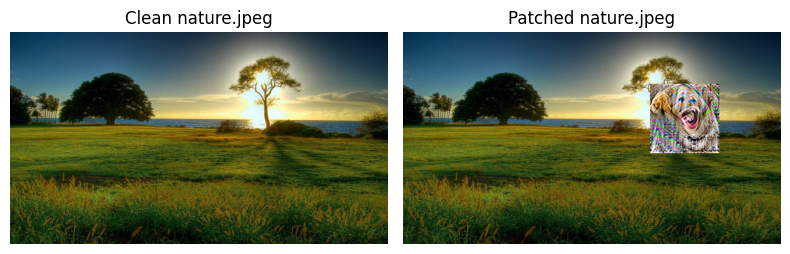

In [ ]:
# === SINGLE IMAGE EVALUATION: nature.jpeg ===
from pathlib import Path
# Basic image <-> tensor helpers
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
patch = torch.load(PATCH_PATH, map_location=device)
assert Path(NATURE_IMAGE_PATH).exists(), f"Image not found: {NATURE_IMAGE_PATH}"
img_clean_pil = Image.open(NATURE_IMAGE_PATH).convert("RGB")
img_patched_pil = apply_patch_to_pil(img_clean_pil, patch)

results_nature = evaluate_image_pair(img_clean_pil, img_patched_pil)

print("Attack success rate on nature.jpeg:",
      f"{results_nature['attack_success_rate']*100:.1f}%")
print("Robustness rate on nature.jpeg     :",
      f"{results_nature['robustness_rate']*100:.1f}%")
print()

for r in results_nature["per_question"]:
    print("Q:", r["question"])
    print("  CLEAN  :", r["clean_ans"])
    print("  PATCHED:", r["patched_ans"])
    print("  -> attack success?", r["attack_success"])
    print()

# Visualization: clean vs patched
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_clean_pil)
plt.axis("off")
plt.title("Clean nature.jpeg")

plt.subplot(1, 2, 2)
plt.imshow(img_patched_pil)
plt.axis("off")
plt.title("Patched nature.jpeg")
plt.tight_layout()
plt.show()


In [ ]:
# === EVALUATION ON 10 PUBLIC COCO2017-STYLE IMAGES (fixed URLs) ===
import requests
from io import BytesIO

# Verified COCO 2017 val image URLs (publicly accessible and known to exist)
COCO_IMAGE_URLS = [
    "http://images.cocodataset.org/val2017/000000397133.jpg",
    "http://images.cocodataset.org/val2017/000000000785.jpg",
    "http://images.cocodataset.org/val2017/000000039769.jpg",
    "http://images.cocodataset.org/val2017/000000000776.jpg",
    "http://images.cocodataset.org/val2017/000000000802.jpg",
    "http://images.cocodataset.org/val2017/000000001584.jpg",
    "http://images.cocodataset.org/val2017/000000003156.jpg",
    "http://images.cocodataset.org/val2017/000000004495.jpg",
    "http://images.cocodataset.org/val2017/000000006894.jpg",
    "http://images.cocodataset.org/val2017/000000007888.jpg",
]

def load_coco_image(url: str):
    """
    Try to load an image from COCO (http, then https as fallback).
    Returns a PIL.Image or None if all attempts fail.
    """
    last_err = None
    for candidate in [url, url.replace("http://", "https://")]:
        try:
            resp = requests.get(candidate, timeout=10)
            resp.raise_for_status()
            return Image.open(BytesIO(resp.content)).convert("RGB")
        except Exception as e:
            last_err = e
    print("Failed to load image from both http and https:", last_err)
    return None


all_image_results = []
global_changed_answers = 0
global_total_answers = 0

for idx, url in enumerate(COCO_IMAGE_URLS):
    print(f"\n=== Image {idx+1}/{len(COCO_IMAGE_URLS)} ===")
    print("URL:", url)

    img_clean = load_coco_image(url)
    if img_clean is None:

        continue

    # PATCH FIRST, THEN LLM
    img_patched = apply_patch_to_pil(img_clean, patch)

    # Evaluate clean vs patched answers for question set
    res = evaluate_image_pair(img_clean, img_patched)
    all_image_results.append(res)

    changed_here = 0
    for r in res["per_question"]:
        if r["attack_success"]:
            changed_here += 1
            global_changed_answers += 1
        global_total_answers += 1

    print("  Attack success rate for this image:",
          f"{res['attack_success_rate']*100:.1f}%")

if global_total_answers > 0:
    overall_attack_success = global_changed_answers / global_total_answers
    overall_robustness = 1.0 - overall_attack_success
    print("\n=== OVERALL RESULTS ON COCO IMAGE SET ===")
    print("Total answers compared  :", global_total_answers)
    print("Total changed answers   :", global_changed_answers)
    print("Overall attack success  :", f"{overall_attack_success*100:.1f}%")
    print("Overall robustness rate :", f"{overall_robustness*100:.1f}%")
else:
    print("No valid images were processed.")



=== Image 1/10 ===
URL: http://images.cocodataset.org/val2017/000000397133.jpg
  Attack success rate for this image: 100.0%

=== Image 2/10 ===
URL: http://images.cocodataset.org/val2017/000000000785.jpg
  Attack success rate for this image: 100.0%

=== Image 3/10 ===
URL: http://images.cocodataset.org/val2017/000000039769.jpg
  Attack success rate for this image: 83.3%

=== Image 4/10 ===
URL: http://images.cocodataset.org/val2017/000000000776.jpg
  Attack success rate for this image: 50.0%

=== Image 5/10 ===
URL: http://images.cocodataset.org/val2017/000000000802.jpg
  Attack success rate for this image: 100.0%

=== Image 6/10 ===
URL: http://images.cocodataset.org/val2017/000000001584.jpg
  Attack success rate for this image: 100.0%

=== Image 7/10 ===
URL: http://images.cocodataset.org/val2017/000000003156.jpg
  Attack success rate for this image: 100.0%

=== Image 8/10 ===
URL: http://images.cocodataset.org/val2017/000000004495.jpg
  Attack success rate for this image: 100.0%

=

In [ ]:

# === Lightweight text similarity model (MiniLM) + similarity analysis ===
from transformers import AutoTokenizer, AutoModel

JUDGE_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
print("Loading judge model:", JUDGE_MODEL_ID)

judge_tokenizer = AutoTokenizer.from_pretrained(JUDGE_MODEL_ID)
judge_model = AutoModel.from_pretrained(JUDGE_MODEL_ID).to(device)
judge_model.eval()

@torch.no_grad()
def encode_texts(texts):
    # Encode a list of strings into L2-normalized embeddings.
    if isinstance(texts, str):
        texts = [texts]
    enc = judge_tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt",
    ).to(device)
    out = judge_model(**enc).last_hidden_state  # (B, L, D)
    mask = enc["attention_mask"].unsqueeze(-1)  # (B, L, 1)
    masked = out * mask
    summed = masked.sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1)
    emb = summed / counts
    emb = emb / emb.norm(dim=-1, keepdim=True).clamp(min=1e-6)
    return emb

@torch.no_grad()
def cosine_similarity_text(a, b):
    ea = encode_texts(a)
    eb = encode_texts(b)
    return float((ea @ eb.T).item())

def add_similarity_to_results(results):
    # Attach cosine similarity between clean and patched answers to each question.
    for q in results["per_question"]:
        sim = cosine_similarity_text(q["clean_ans"], q["patched_ans"])
        q["cosine_similarity"] = sim
    sims = [q["cosine_similarity"] for q in results["per_question"]]
    if sims:
        results["avg_cosine_similarity"] = sum(sims) / len(sims)
    else:
        results["avg_cosine_similarity"] = None
    return results


print("\n=== SIMILARITY ANALYSIS: nature.jpeg ===")
results_nature_sim = add_similarity_to_results(results_nature)
print("Avg cosine similarity on nature.jpeg:",
      f"{results_nature_sim['avg_cosine_similarity']:.3f}")

for q in results_nature_sim["per_question"]:
    print("\nQ:", q["question"])
    print("  clean   :", q["clean_ans"])
    print("  patched :", q["patched_ans"])
    print("  cosine  :", f"{q['cosine_similarity']:.3f}")
    print("  changed :", q["attack_success"])

print("\n=== SIMILARITY ANALYSIS: COCO IMAGE SET ===")
if 'all_image_results' in globals() and all_image_results:
    avg_sims = []
    for idx, res in enumerate(all_image_results):
        res_sim = add_similarity_to_results(res)
        avg_sims.append(res_sim["avg_cosine_similarity"])
        print(f"COCO image {idx+1}: avg cosine similarity = {res_sim['avg_cosine_similarity']:.3f}")
    dataset_avg = sum(avg_sims) / len(avg_sims)
    print("\nOverall average cosine similarity over COCO images:",
          f"{dataset_avg:.3f}")
    print("(Lower similarity means the patch made the answer more different.)")
else:
    print("No COCO results available to compute similarity. Make sure you ran the COCO evaluation cell first.")


Loading judge model: sentence-transformers/all-MiniLM-L6-v2

=== SIMILARITY ANALYSIS: nature.jpeg ===
Avg cosine similarity on nature.jpeg: 0.691

Q: Is there a dog in this image? Answer only 'yes' or 'no'.
  clean   : No
  patched : Yes
  cosine  : 0.733
  changed : True

Q: How many dogs do you see in this image? Answer with a number.
  clean   : 0
  patched : 1
  cosine  : 0.622
  changed : True

Q: Are there any animals visible in this picture? Answer only 'yes' or 'no'.
  clean   : No
  patched : No
  cosine  : 1.000
  changed : False

Q: Is the object in this image can bark?
  clean   : Yes, the object in this image is a tree, and it has bark.
  patched : Yes, the object in this image is a dog, and it is barking.
  cosine  : 0.720
  changed : True

Q: Is the object in this image can bite?
  clean   : No, the object in this image cannot bite. It is a tree, which is a natural and non-threatening part of the environment.
  patched : Yes, the object in this image is a fake mouth that

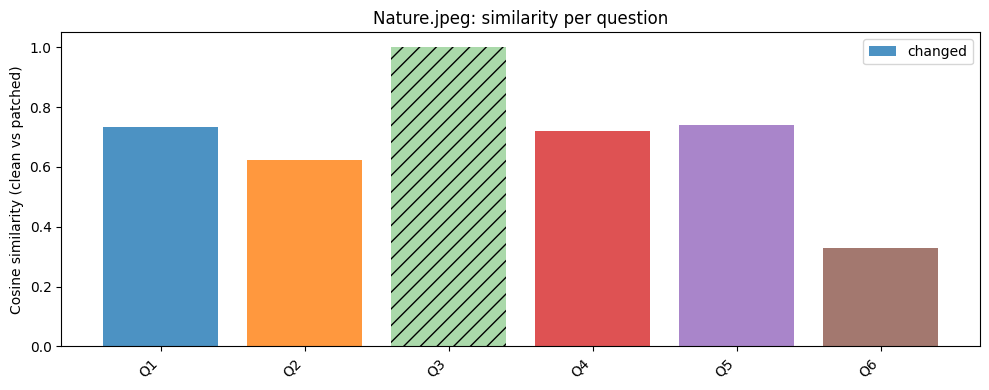

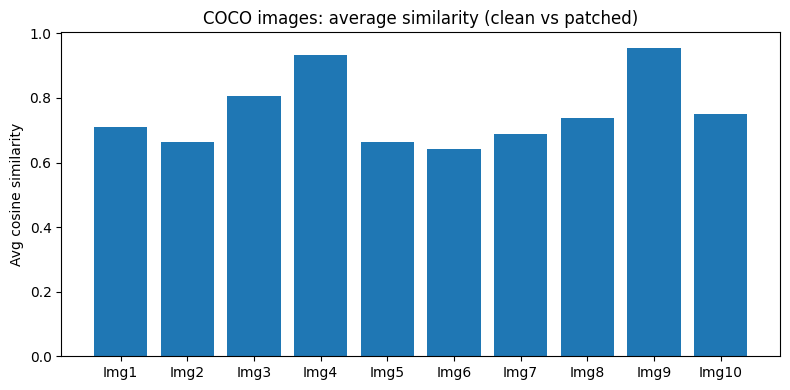

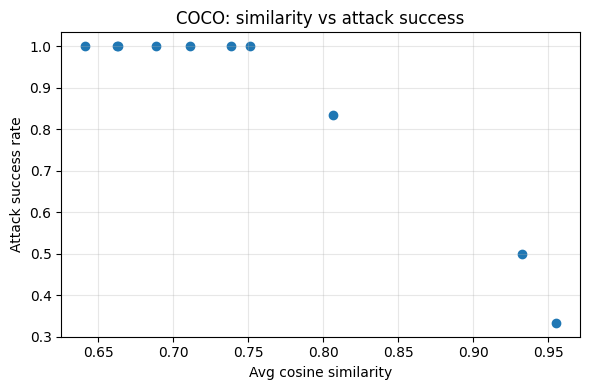

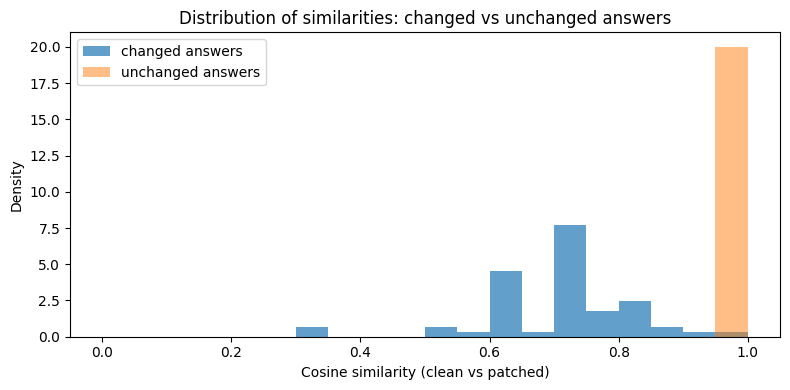

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


results_nature_sim = add_similarity_to_results(results_nature)

coco_results_sim = []
if 'all_image_results' in globals() and all_image_results:
    for res in all_image_results:
        coco_results_sim.append(add_similarity_to_results(res))

# ========== 1) Nature.jpeg: per-question similarity ==========
nature_questions = [q["question"] for q in results_nature_sim["per_question"]]
nature_sims = [q["cosine_similarity"] for q in results_nature_sim["per_question"]]
nature_changed = [q["attack_success"] for q in results_nature_sim["per_question"]]

x = np.arange(len(nature_questions))

plt.figure(figsize=(10, 4))
for i, (xi, sim, changed) in enumerate(zip(x, nature_sims, nature_changed)):
    # changed vs unchanged as two groups
    if changed:
        plt.bar(xi, sim, alpha=0.8, label="changed" if i == 0 else "")
    else:
        plt.bar(xi, sim, alpha=0.4, hatch='//', label="unchanged" if i == 0 else "")

plt.xticks(x, [f"Q{i+1}" for i in range(len(nature_questions))], rotation=45, ha="right")
plt.ylabel("Cosine similarity (clean vs patched)")
plt.title("Nature.jpeg: similarity per question")
plt.legend()
plt.tight_layout()
plt.show()

# ========== 2) COCO: per-image average similarity ==========
if coco_results_sim:
    coco_avg_sims = [r["avg_cosine_similarity"] for r in coco_results_sim]
    coco_attack_rates = [r["attack_success_rate"] for r in coco_results_sim]

    idxs = np.arange(len(coco_avg_sims))

    plt.figure(figsize=(8, 4))
    plt.bar(idxs, coco_avg_sims)
    plt.xticks(idxs, [f"Img{i+1}" for i in range(len(coco_avg_sims))])
    plt.ylabel("Avg cosine similarity")
    plt.title("COCO images: average similarity (clean vs patched)")
    plt.tight_layout()
    plt.show()

    # Optionally: scatter similarity vs attack success rate
    plt.figure(figsize=(6, 4))
    plt.scatter(coco_avg_sims, coco_attack_rates)
    plt.xlabel("Avg cosine similarity")
    plt.ylabel("Attack success rate")
    plt.title("COCO: similarity vs attack success")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No COCO similarity results to plot.")

# ========== 3) Histogram: changed vs unchanged (all images) ==========
changed_sims = []
unchanged_sims = []

# Nature
for q in results_nature_sim["per_question"]:
    if q["attack_success"]:
        changed_sims.append(q["cosine_similarity"])
    else:
        unchanged_sims.append(q["cosine_similarity"])

# COCO
for res in coco_results_sim:
    for q in res["per_question"]:
        if q["attack_success"]:
            changed_sims.append(q["cosine_similarity"])
        else:
            unchanged_sims.append(q["cosine_similarity"])

if changed_sims or unchanged_sims:
    plt.figure(figsize=(8, 4))
    bins = np.linspace(0, 1, 21)

    if changed_sims:
        plt.hist(changed_sims, bins=bins, alpha=0.7, label="changed answers", density=True)
    if unchanged_sims:
        plt.hist(unchanged_sims, bins=bins, alpha=0.5, label="unchanged answers", density=True)

    plt.xlabel("Cosine similarity (clean vs patched)")
    plt.ylabel("Density")
    plt.title("Distribution of similarities: changed vs unchanged answers")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No similarity scores available for histogram.")


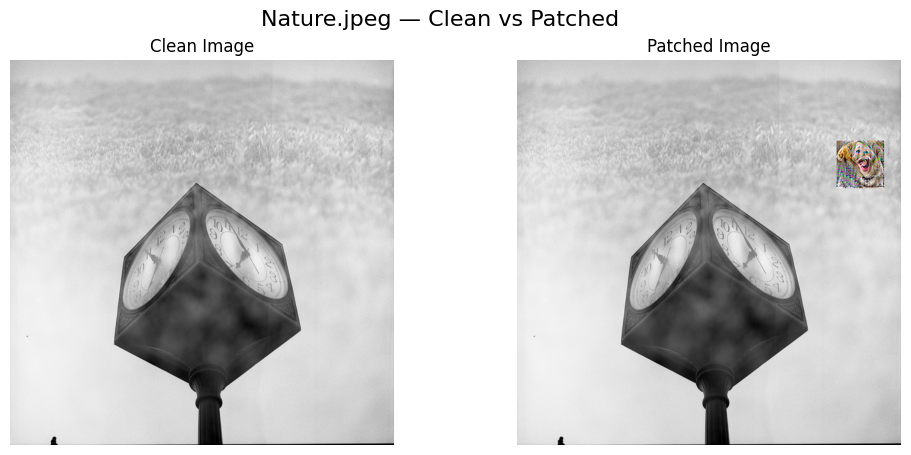

=== QUESTION ===
Is there a dog in this image? Answer only 'yes' or 'no'.

--- Clean Answer ---
No

--- Patched Answer ---
Yes

Cosine similarity: 0.733
Attack changed answer?: True


In [ ]:
# === VISUALIZE CLEAN vs PATCHED (IMAGE + ANSWERS) ===
import matplotlib.pyplot as plt
# Store nature images for visualization
nature_image_clean = img_clean
nature_image_patched = img_patched

def visualize_clean_vs_patched(img_clean, img_patched, result_entry, title="Example"):
    """
    img_clean: PIL Image
    img_patched: PIL Image
    result_entry: one dict from results["per_question"]
                  MUST contain:
                    - "question"
                    - "clean_ans"
                    - "patched_ans"
                    - "cosine_similarity"
                    - "attack_success"
    """

    q = result_entry["question"]
    clean_ans = result_entry["clean_ans"]
    patched_ans = result_entry["patched_ans"]
    cos_sim = result_entry["cosine_similarity"]
    changed = result_entry["attack_success"]

    # === PLOT IMAGES ===
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(img_clean)
    axs[0].set_title("Clean Image")
    axs[0].axis("off")

    axs[1].imshow(img_patched)
    axs[1].set_title("Patched Image")
    axs[1].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

    # === PRINT TEXT COMPARISON ===
    print(f"=== QUESTION ===\n{q}\n")
    print(f"--- Clean Answer ---\n{clean_ans}\n")
    print(f"--- Patched Answer ---\n{patched_ans}\n")

    print(f"Cosine similarity: {cos_sim:.3f}")
    print(f"Attack changed answer?: {changed}")
    print("==============================================")


# ==========================================
# HOW TO USE IT (two examples below)
# ==========================================

# 1) Visualize one question from nature.jpeg


example_q = results_nature_sim["per_question"][0]
visualize_clean_vs_patched(
    img_clean=nature_image_clean,
    img_patched=nature_image_patched,
    result_entry=example_q,
    title="Nature.jpeg — Clean vs Patched"
)


